In [1]:
import pandas as pd
import numpy as np
import ot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import BaseTransport, calc_parsimony

In [2]:
# Experiment hyperparamters
rng = np.random.RandomState(42)

In [3]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

## Loading and Preprocessing the data


In [4]:
from data_utils import load_and_preprocess_nba_data
continuous_variables_indicies = [0,1,2]
# n_samples = 'balanced'
# n_samples = 1000
X, Y, feature_names = load_and_preprocess_nba_data(rng, return_column_names=True)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(X)
print(Y)
source_target_path = open('./File_Paths/path_source_target.txt', 'r').read()
parameters = pd.read_csv(f'../{source_target_path}/experiment_parameters.csv')
split_on = parameters['split_feature'].values[0]
instance_1 = parameters['instance_1'].values[0]
instance_2 = parameters['instance_2'].values[0]


Splitting on Team with LAL and MIA resulting source shape: (238, 3), target shape: (238, 3).
###############################
['Age', 'MinutesPlayed', 'PointsScored']
###############################
######################## Source_Data_A Dropped ##########################
     Age  MinutesPlayed  PointsScored
115   25          250.3            69
15    24          179.0            80
212   23           41.1            12
126   22           92.9            19
6     31           73.0            15
..   ...            ...           ...
106   30          939.7           695
14    29          416.8           118
92    38            0.9             0
179   23          831.9           506
102   30           96.2            18

[238 rows x 3 columns]
########################### Source_Data_B Dropped #######################
     Age  MinutesPlayed  PointsScored
95    34          168.6            40
40    32            3.5             0
6     27          125.6            24
197   31           26.

## Performing Clustering

In [5]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [6]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [7]:
## Hyperparameters
max_clusters = 10

In [8]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 0.214, Par: 0.000, Inter: 0
Fid: 0.171, Par: 10.274, Inter: 1
Fid: 0.160, Par: 16.829, Inter: 2
Fid: 0.145, Par: 18.018, Inter: 3
Fid: 0.147, Par: 31.456, Inter: 4
Fid: 0.143, Par: 86.712, Inter: 5
Fid: 0.128, Par: 53.621, Inter: 6
Fid: 0.131, Par: 121.252, Inter: 7
Fid: 0.120, Par: 129.296, Inter: 8
Fid: 0.120, Par: 142.810, Inter: 9
Fid: 0.120, Par: 159.709, Inter: 10


In [9]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on Team:


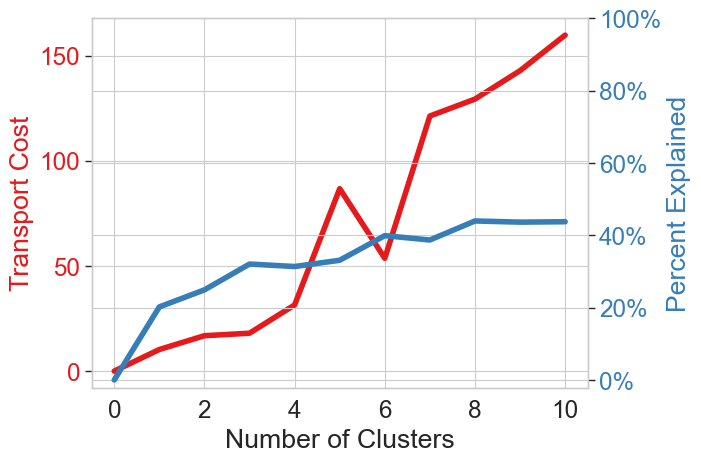

In [10]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)


print(f'Results with splitting on {split_on}:')
if save_figures: plt.savefig(
    figure_dir / f'logitics_data_on{split_on}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

In [11]:
nba_dict = {}
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    tgt = f'{instance_2}'
    src = f'{instance_1}'
    nba_dict[record_idx] = {}
    print(f'Starting {n_clusters} cluster results:')
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t         Names={[name[:3] for name in feature_names]}')
            print(f'\t\t   {src}_mean={X[cluster_idx==labels].mean(axis=0)}')
            print(f'\t\tT({tgt})_mean={Z_clusters[cluster_idx==labels].mean(axis=0)}')
            nba_dict[record_idx][cluster_idx] = {}

            nba_dict[record_idx][cluster_idx]['src_means'] = X[cluster_idx==labels].mean(axis=0)
            nba_dict[record_idx][cluster_idx]['trg_means'] = Z_clusters[cluster_idx==labels].mean(axis=0)

        print()

      

Starting 1 cluster results:
	Cluster: 0
		         Names=['Age', 'Min', 'Poi']
		   LAL_mean=[ 28.185 255.38  105.983]
		T(MIA)_mean=[ 29.126 253.163  99.555]

Starting 2 cluster results:
	Cluster: 0
		         Names=['Age', 'Min', 'Poi']
		   LAL_mean=[ 29.098 610.53  283.721]
		T(MIA)_mean=[ 28.754 612.133 269.295]
	Cluster: 1
		         Names=['Age', 'Min', 'Poi']
		   LAL_mean=[ 27.87  132.984  44.729]
		T(MIA)_mean=[ 29.254 129.45   41.056]

Starting 3 cluster results:
	Cluster: 0
		         Names=['Age', 'Min', 'Poi']
		   LAL_mean=[27.667 96.446 30.946]
		T(MIA)_mean=[29.054 90.392 29.184]
	Cluster: 1
		         Names=['Age', 'Min', 'Poi']
		   LAL_mean=[ 28.985 414.436 149.09 ]
		T(MIA)_mean=[ 29.522 431.621 146.582]
	Cluster: 2
		         Names=['Age', 'Min', 'Poi']
		   LAL_mean=[ 29.125 784.821 445.25 ]
		T(MIA)_mean=[ 28.458 751.937 399.292]

Starting 4 cluster results:
	Cluster: 0
		         Names=['Age', 'Min', 'Poi']
		   LAL_mean=[ 29.491 511.625 193.547]
		T(MIA)_mean=

In [14]:
# Assuming max_clusters and nba_dict are predefined elsewhere in your script
vis_clusters = max_clusters
total_distance = []
attributes_list_names = feature_names

# Initialize differences for each cluster
for cluster_idx in range(0, vis_clusters):
    nba_dict[vis_clusters-1][cluster_idx]["differences"] = {}

# Calculate distances for all clusters and attributes
for cluster_idx in range(0, vis_clusters):
    for i, attribute in enumerate(attributes_list_names):
        val_0 = nba_dict[vis_clusters-1][cluster_idx]['src_means'][i]
        val_1 = nba_dict[vis_clusters-1][cluster_idx]['trg_means'][i]
        nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] = abs(val_1 - val_0)

    # Calculate the total distance for the cluster
    total_distance.append(np.sqrt(sum((nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute]) ** 2 for attribute in attributes_list_names)))

# Create a DataFrame with the calculated differences
distances = pd.DataFrame({
    'Cluster': range(vis_clusters),
    'Total_distance': total_distance
})

# Add each attribute's differences as a separate column
for attribute in attributes_list_names:
    distances[attribute] = [nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] for cluster_idx in range(vis_clusters)]

# Sort distances by total distance
distances = distances.sort_values(by='Total_distance')

display(distances)
distance_folder_path = open('./File_Paths/path_distances.txt', 'r').read()
output_path = f'../{distance_folder_path}/distance_from_{instance_1}_to_{instance_2}.csv'
distances.to_csv(output_path, index=False)


,Cluster,Total_distance,Age,MinutesPlayed,PointsScored
8,8,1.630979,1.282051,0.128205,1.000000
3,3,2.956379,1.100000,2.180000,1.666667
6,6,2.972317,2.142857,0.223810,2.047619
9,9,7.200075,5.861111,4.161111,0.416667
5,5,18.767625,0.636364,18.740909,0.772727
1,1,18.851355,12.700000,3.440000,13.500000
0,0,29.001307,0.592593,25.055556,14.592593
7,7,30.819553,3.058824,27.964706,12.588235
4,4,43.723597,1.272727,43.504545,4.181818
2,2,92.020701,1.714286,41.014286,82.357143


In [15]:
# ergonomic blank space : ) 






























































